In [1]:
try:
    # always cd to the right directory in google colab
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/MyDrive/Colab Notebooks/deep_branching_with_domain"
except:
    pass

import os
import sys
import numbers
import math
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import cm 
import numpy as np
from scipy.stats import norm
from functools import partial
from IPython.display import Markdown as md
# add parent directory to system so that we can import the modules correctly
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from branch.galerkin import DGMNet
from branch.branch import Net

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The formula given by Borodin

In [2]:
def conditional_probability_to_survive(
    t,
    x,
    y,
    k_arr=range(-5, 5),
    lower_bound=-10,
    upper_bound=10,
):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose (t, x, y)
    # so that the operation with lower_bound, upper_bound is correct
    t = t.unsqueeze(dim=0).transpose(0, -1)
    x, y = x.transpose(0, -1), y.transpose(0, -1)

    # calculate the probability using the formula by Borodin
    ans = 0
    for k in k_arr:
        ans += (
            torch.exp(
                ((y - x) ** 2 - (y - x + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
            - torch.exp(
                ((y - x) ** 2 - (y + x - 2*lower_bound + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
        )
    # print(ans.transpose(0, -1).prod(dim=0))
    return ans.transpose(0, -1).prod(dim=0)

def is_x_inside(x, lower_bound=-10, upper_bound=10):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose x so that the operation with lower_bound, upper_bound is correct
    x = x.transpose(0, -1)

    return (
        torch.logical_and(lower_bound <= x, x <= upper_bound)
        .transpose(0, -1).all(dim=0)
    )

In [3]:
# for plotting NS equation
def plot_wall(model, nb_spatial, x_lo, x_hi):
    lw, delta = 5, 1e-1
    plt.axis('scaled')
    plt.xlim(x_lo, x_hi)
    plt.ylim(x_lo, x_hi)

def plot_quiver_and_color(model, tt, x_lo, x_hi, x1, x2, u, nb_spatial, vmin=None, vmax=None, plt_velocity=True):
    # for velocity, the magnitute is the length
    # for pressure, the magnitute is simply itself
    magnitute = torch.sqrt(u[0]**2 + u[1]**2) if plt_velocity else u[0]
    subject = "velocity" if plt_velocity else "pressure"
    f = plt.figure()
    s = f.add_subplot(1, 1, 1, xlabel='$x$', ylabel='$y$')
    cmap=cm.coolwarm
    im = s.imshow(
        magnitute.reshape(nb_spatial, nb_spatial),
        cmap=cmap,
        extent=(x_lo, x_hi, x_lo, x_hi),
        origin='lower',
        vmin=vmin,
        vmax=vmax,
    )
    f.colorbar(im)
    plot_wall(model, nb_spatial, x_lo, x_hi)
    
    if plt_velocity:
        # use coarser grid
        x1 = x1.reshape(nb_spatial, nb_spatial)[::5, ::5].reshape(-1)
        x2 = x2.reshape(nb_spatial, nb_spatial)[::5, ::5].reshape(-1)
        u = u.reshape(2, nb_spatial, nb_spatial)[:, ::5, ::5].reshape(2, -1)
        plt.quiver(x1, x2, u[0], u[1], scale=10*(vmax - vmin))
        plt.title(f"{subject} flow at t = {tt}")
    plt.title(f"{subject} flow at t = {tt}")
    f.savefig(f"../{model.working_dir}/plot/t{tt}_{subject}.png", bbox_inches="tight", dpi=300)
    if isinstance(tt, numbers.Number) and (math.isclose(tt, model.t_lo) or math.isclose(tt, model.T)):
        plt.show()
    plt.close()

def plot_fluid(model, nb_time=21, nb_spatial=101, x_lo=None, x_hi=None):
    x_lo = model.x_lo if x_lo is None else x_lo
    x_hi = model.x_hi if x_hi is None else x_hi
    x1, x2 = np.meshgrid(
        np.linspace(x_lo, x_hi, nb_spatial + 2)[1:-1],
        np.linspace(x_lo, x_hi, nb_spatial + 2)[1:-1]
    )
    x1, x2 = x1.reshape(-1), x2.reshape(-1)
    time_arr = np.linspace(model.t_lo, model.T, nb_time)
    u = []
    for tt in time_arr:
        # create x
        x_tensor = torch.tensor(
            np.stack((tt * np.ones_like(x1), x1, x2)),
            device=model.device,
            dtype=torch.get_default_dtype()
        ).reshape(3, -1)
    
        # calculate u
        u.append(model(x_tensor.T, patch=0).T.detach().cpu())
    # merge all u together
    u = torch.stack(u, dim=0)
    
    # calculate terminal u & p
    terminal_u = torch.stack((
        model.phi_fun(x_tensor[1:], 0).cpu(),
        model.phi_fun(x_tensor[1:], 1).cpu(),
    ))
    p = model(x_tensor[1:].T, patch=0, p_or_u="p").T.detach().cpu()
    
    # plot
    magnitute = torch.sqrt(u[:, 0, :]**2 + u[:, 1, :]**2)
    magnitute = magnitute[~magnitute.isnan()]  # filter nan
    vmin, vmax = magnitute.min().item(), magnitute.max().item()
    for idx, tt in enumerate(time_arr):
        plot_quiver_and_color(model, tt, x_lo, x_hi, x1, x2, u[idx], nb_spatial, vmin, vmax)
    plot_quiver_and_color(model, "terminal", x_lo, x_hi, x1, x2, terminal_u, nb_spatial, vmin, vmax)
    plot_quiver_and_color(model, model.T, x_lo, x_hi, x1, x2, p, nb_spatial, plt_velocity=False)
    
    return x1, x2, u, p

## Time-dependent Poiseuille flow
We consider the 2D Navier-Stokes equation inside the square $[-L, L]^2$. For this, we let the wall be the horizontal lines $y = L$ and $y = L$, and let the inlet at $x = -L$ flowing to the direction $x = L$.

It can be checked that the velocity flow $u(t, x, y) = (g(t, y), 0)$ with the pressure $p(t, x, y) = \alpha v_0^2 - \frac{\nu v_0}{L^2} x$ satisfies the Navier-Stokes equation
$$
\partial_t u(t,x) + \frac{\nu}{2} \Delta u(t,x) =\nabla p(t,x) + ( u \cdot \nabla ) u,
$$
with the divergence free condition ${\rm div \ \! } u = 0$,
where
$$
g(t, y) = v_0 \left( 1 - \frac{y^2}{L^2} \right) + \sum\limits_{n=0}^\infty \frac{(-1)^{n+1} 32 v_0}{\pi^3(2n+1)^3} \cos \frac{(2n+1)\pi y}{2L} \exp\left(- \frac{(2n+1)^2 \pi^2 \nu (T-t)}{8L^2}\right),
$$
see [this article](https://www.researchgate.net/publication/222552962_SPH_simulations_of_time-dependent_Poiseuille_flow_at_low_Reynolds_numbers).

In [4]:
problem_name = "navier_stokes_poiseuille"
nu = 2e-6
v0 = 1.25e-5
# v0 = 1
L = 5e-4
# L = 5e1
alpha = 2

t_lo, x_lo, x_hi = 0., -L, L

# function definition
deriv_map = np.array(
    [
        [1, 0],  # for nabla p
        [0, 1],
        [0, 0],  # for u
        [0, 0],
        [1, 0],  # for nabla u1
        [0, 1],
        [1, 0],  # for nabla u2
        [0, 1],
    ]
)
zeta_map = np.array([-1, -1, 0, 1, 0, 0, 1, 1])
deriv_condition_deriv_map = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1])
_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        ans = v0 * (1 - x[1]**2/L**2)
        for n in range(5):
            ans += (
                32 * (-1)**(n+1) * v0 / (math.pi * (2*n+1))**3
                * torch.cos((2*n+1) * math.pi * x[1] / (2 * L))
            )
        return ans
    else:
        return torch.zeros_like(x[0])

def exact_example(t, x, T, coordinate):
    if coordinate == 0:
        ans = v0 * (1 - x[1]**2/L**2)
        for n in range(5):
            ans += (
                32 * (-1)**(n+1) * v0 / (math.pi * (2*n+1))**3
                * np.cos((2*n+1) * math.pi * x[1] / (2 * L))
                * np.exp(
                    -((2*n+1)**2 * math.pi**2 * nu * (T - t))/(8 * L**2)
                )
            )
        return ans
    else:
        return np.zeros_like(x[0])

def p_example_full(x, t):
    return alpha * v0**2 - nu * v0 / L**2 * x[0]

Logs are saved in /home/nguwijy/deep_branching_with_domain/logs/tmp
Patch 0: generation of u samples take 166.061096906662 seconds.
Patch  0: epoch    0 with loss 2.47E+00
Patch  0: epoch  500 with loss 3.16E-05
Patch  0: epoch 1000 with loss 7.04E-06
Patch  0: epoch 1500 with loss 1.28E-04
Patch  0: epoch 2000 with loss 8.75E-05
Patch  0: epoch 2500 with loss 1.93E-06
Patch  0: epoch 3000 with loss 1.96E-06
Patch  0: epoch 3500 with loss 3.76E-06
Patch  0: epoch 4000 with loss 1.52E-06
Patch  0: epoch 4500 with loss 2.00E-06
Patch  0: epoch 4999 with loss 1.51E-05
Patch 0: training of u with 5000 epochs take 38.37777543067932 seconds.


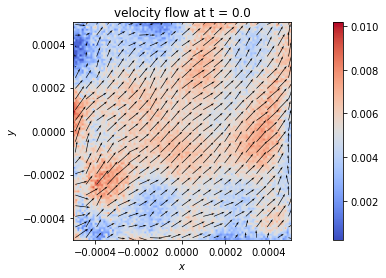

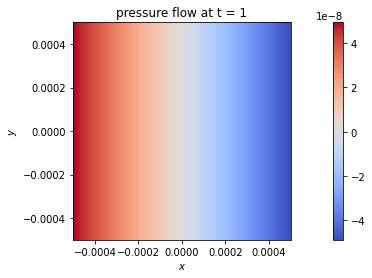

In [6]:
patches = 1
T = patches * 1
MAX_VAL = 100

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    exact_p_fun_full=p_example_full,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    branch_nb_states=10000,  # change to 100000
    branch_nb_states_per_batch=1000,
    epochs=5000,  # change to 10000
    fix_all_dim_except_first=False,  # change to False
    fix_t_dim=True,  # change to False
    overtrain_rate=0.,
    outlier_multiplier=10,
    save_as_tmp=True,  # change to False
    div_condition_coeff=0.,  # remove this??
)
model.train_and_eval(debug_mode=False)
x1, x2, u, p = plot_fluid(model, nb_time=1)  # change to 21

In [37]:
# save the previous parameters
nb_states = model.nb_states
nb_path_per_state = model.nb_path_per_state
adjusted_x_boundaries = model.adjusted_x_boundaries

# override to force generation of 1 very precise sample
model.nb_states = 1
model.nb_path_per_state = 1000000
model.adjusted_x_boundaries = (0, 0)

# generate MC samples and show the results
torch.manual_seed(0)
x, y = model.gen_sample(patch=0)
print(f"The MC evaluation with {model.nb_path_per_state} paths at t = {x[0, 0].item()}, x0 = {x[0, 1].item()}, "
      f"and x1 = {x[0, 2].item()} is u0 = {y[0, 0].item()} and u1 = {y[0, 1].item()}.")
print(f"The exact solution is u0 = {exact_example(0, x.cpu().T, T, 0).item()} "
      f"and u1 = {exact_example(0, x.cpu().T, T, 1).item()}.")

# revert to the previous parameters
model.nb_states = nb_states
model.nb_path_per_state = nb_path_per_state
model.adjusted_x_boundaries = adjusted_x_boundaries

The MC evaluation with 1000000 paths at t = 0.0, x0 = 0.0, and x1 = 0.0 is u0 = -1.4610322017632473e-15 and u1 = 0.0.
The exact solution is u0 = 1.2499332115112338e-05 and u1 = 0.0.


In [7]:
md(f"[Link to log directory:](../{model.working_dir})")

[Link to log directory:](../logs/tmp)

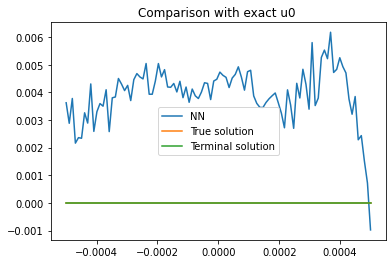

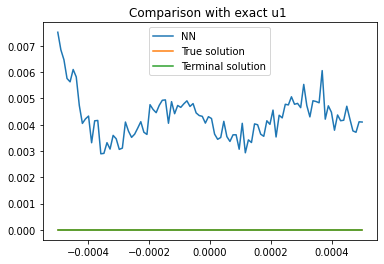

In [8]:
model.compare_with_exact(exact_fun=exact_example)